# RQ 1: Finding the most frequent type of question
All json files used should be placed in a folder under the root (where this notebook is placed) named 'snapshot'.

In this example, we used:
20230727_195816_hn_sharings.json
20230727_200003_commit_sharings.json

In [2]:
import pandas as pd
import os
import json

# Directory containing the JSON files
directory = 'snapshot'

# Initialize an empty list to hold DataFrames
df_list = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
            # Extract and process the data from the JSON file
            sources = data["Sources"]
            for source in sources:
                if "ChatgptSharing" in source:
                    for chat in source["ChatgptSharing"]:
                        if "Conversations" in chat:
                            for convo in chat["Conversations"]:
                                # Merge nested fields with top-level fields
                                merged_data = {
                                    "Type": source.get("Type"),
                                    "ID": source.get("ID"),
                                    "URL": source.get("URL"),
                                    "Author": source.get("Author"),
                                    "Points": source.get("Points"),
                                    "Title": source.get("Title"),
                                    "ChatURL": chat.get("URL"),
                                    "DateOfConversation": chat.get("DateOfConversation"),
                                    **convo,  # Include fields from 'Conversations'
                                }
                                # Append each processed record as a DataFrame row
                                df_list.append(merged_data)

# Combine all DataFrames into one
combined_df = pd.DataFrame(df_list)

# Display the resulting DataFrame
print(combined_df)



             Type        ID  \
0     hacker news  36862850   
1     hacker news  36852545   
2     hacker news  36852545   
3     hacker news  36852545   
4     hacker news  36852545   
...           ...       ...   
1233       commit      None   
1234       commit      None   
1235       commit      None   
1236       commit      None   
1237       commit      None   

                                                    URL         Author  \
0         https://news.ycombinator.com/item?id=36862850         cbowal   
1         https://news.ycombinator.com/item?id=36852545        warrenm   
2         https://news.ycombinator.com/item?id=36852545        warrenm   
3         https://news.ycombinator.com/item?id=36852545        warrenm   
4         https://news.ycombinator.com/item?id=36852545        warrenm   
...                                                 ...            ...   
1233  https://github.com/hoshotakamoto/banzukesurfin...  hoshotakamoto   
1234  https://github.com/hoshotakam

What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most commonly present to ChatGPT?

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer function that filters words and performs lemmatization
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):  # Disable unnecessary processing for efficiency
        return " ".join([t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ", "NOUN", "VERB"]])

# Apply the tokenizer to the "Prompt" column
combined_df["ProcessedPrompt"] = combined_df["Prompt"].astype(str).apply(custom_tokenizer)

# Display a preview of the updated DataFrame
print(combined_df[["Prompt", "ProcessedPrompt"]].head())



                                              Prompt  \
0  Write a training plan for a series of lessons ...   
1  nine hundred alda in meters.    If you don't h...   
2  I wouldn't have expected a fathom to be that u...   
3      what's the world record furthest sniper shot?   
4  Yeah, so Jochi Kasar got a very significant % ...   

                                     ProcessedPrompt  
0  write training plan series lesson teach modern...  
1  alda meter reference try follow definition use...  
2  expect unit think depth figure nautical defini...  
3                     world record furth sniper shot  
4  get significant mongolian bow skeptical impres...  


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words="english")
dtm = vectorizer.fit_transform(combined_df["ProcessedPrompt"])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust topics as needed
lda.fit(dtm)

# Display top words for each topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}: ", [words[i] for i in topic.argsort()[-10:]])

# Assign dominant topic to each prompt
topic_results = lda.transform(dtm)
combined_df["Topic"] = topic_results.argmax(axis=1)

# Display results
print(combined_df[["Prompt", "Topic"]].head())

Topic 1:  ['help', 'run', 'try', 'description', 'schema', 'work', 'example', 'create', 'true', 'type']
Topic 2:  ['change', 'solve', 'plan', 'export', 'create', 'script', 'const', 'task', 'file', 'import']
Topic 3:  ['try', 'thing', 'new', 'work', 'want', 'pick', 'game', 'return', 'think', 'user']
Topic 4:  ['let', 'level', 'new', 'property', 'text', 'buffer', 'schedule', 'element', 'org', 'headline']
Topic 5:  ['project', 'need', 'async', 'return', 'task', 'await', 'prompt', 'file', 'import', 'const']
                                              Prompt  Topic
0  Write a training plan for a series of lessons ...      2
1  nine hundred alda in meters.    If you don't h...      2
2  I wouldn't have expected a fathom to be that u...      2
3      what's the world record furthest sniper shot?      2
4  Yeah, so Jochi Kasar got a very significant % ...      4


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                1238 non-null   object 
 1   ID                  639 non-null    object 
 2   URL                 1238 non-null   object 
 3   Author              1238 non-null   object 
 4   Points              637 non-null    float64
 5   Title               637 non-null    object 
 6   ChatURL             1238 non-null   object 
 7   DateOfConversation  1238 non-null   object 
 8   Prompt              1238 non-null   object 
 9   Answer              1238 non-null   object 
 10  ListOfCode          1238 non-null   object 
 11  ProcessedPrompt     1238 non-null   object 
 12  Topic               1238 non-null   int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 125.9+ KB


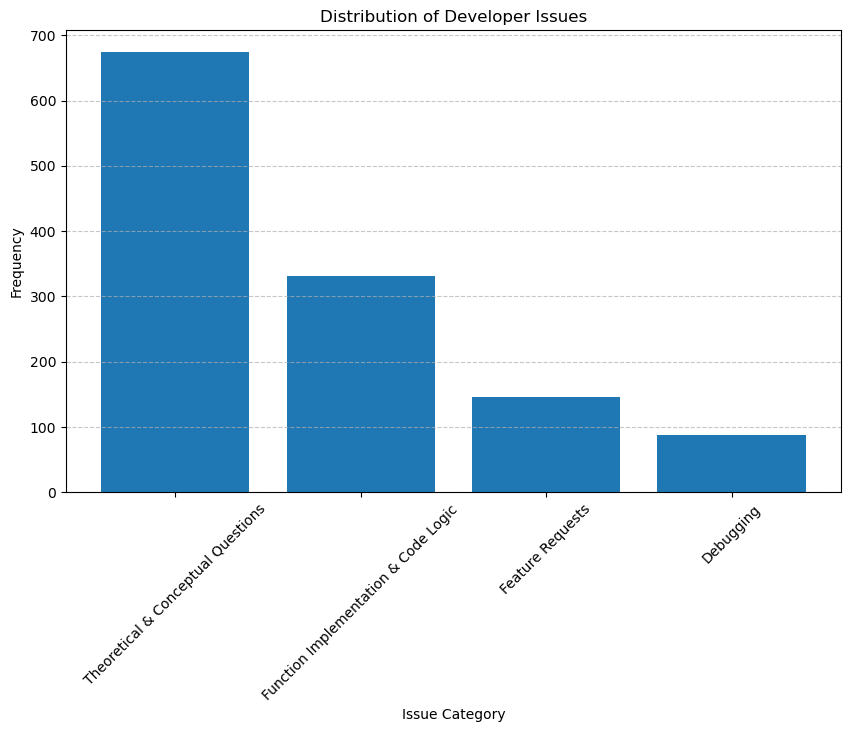

In [6]:
import matplotlib.pyplot as plt
topic_mapping = {
    0: "Function Implementation & Code Logic",
    1: "Theoretical & Conceptual Questions",
    2: "Theoretical & Conceptual Questions",
    3: "Debugging",
    4: "Feature Requests"
}
combined_df["IssueCategory"] = combined_df["Topic"].map(topic_mapping)

# Count occurrences of each issue category
issue_counts = combined_df["IssueCategory"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(issue_counts.index, issue_counts.values)
plt.xlabel("Issue Category")
plt.ylabel("Frequency")
plt.title("Distribution of Developer Issues")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# RQ 2: Finding the typical structure (length) of conversations

Average number of turns per conversation: 4.13
count    300.000000
mean       4.126667
std        6.884422
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       61.000000
Name: Prompt, dtype: float64


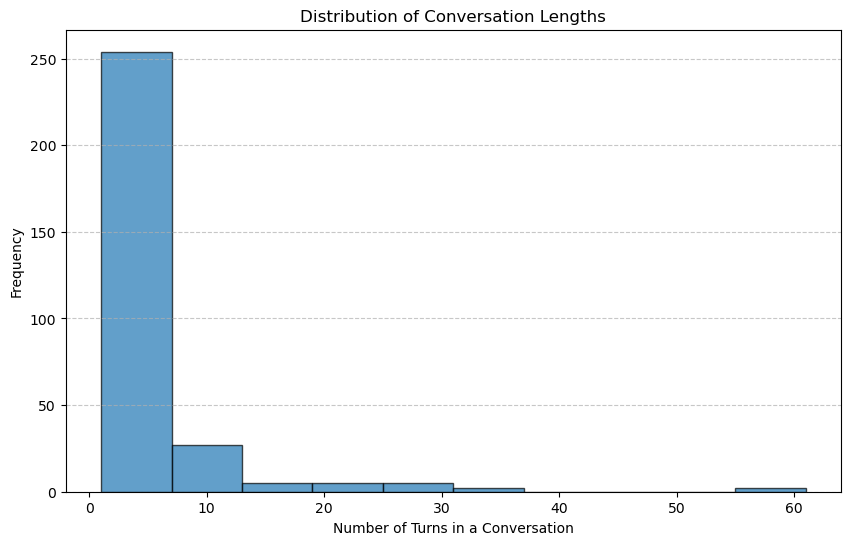

In [7]:
conversation_lengths = combined_df.groupby("URL")["Prompt"].count()

# Compute average number of turns per conversation
average_turns = conversation_lengths.mean()

# Display summary statistics
print(f"Average number of turns per conversation: {average_turns:.2f}")
print(conversation_lengths.describe())  # Show additional stats (min, max, percentiles)

# Plot histogram of conversation lengths
plt.figure(figsize=(10, 6))
plt.hist(conversation_lengths, bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Number of Turns in a Conversation")
plt.ylabel("Frequency")
plt.title("Distribution of Conversation Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [8]:
len(conversation_lengths)

300

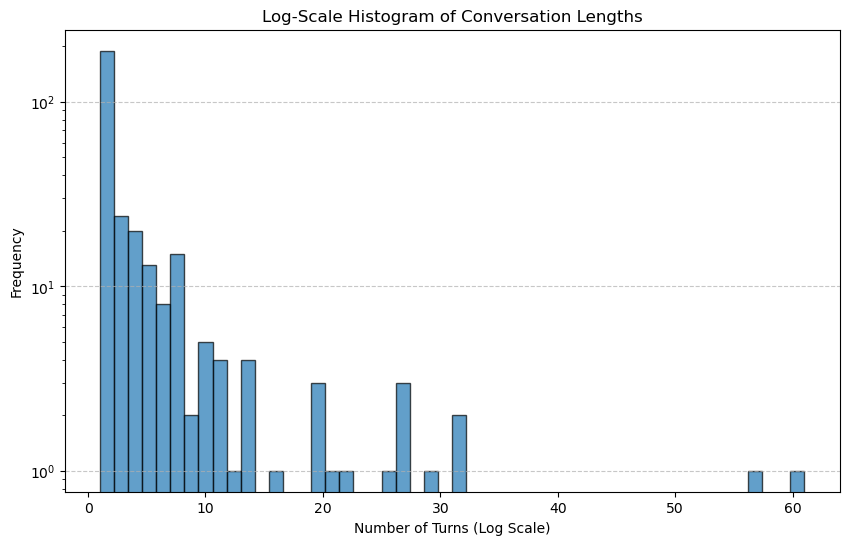

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(conversation_lengths, bins=50, edgecolor="black", alpha=0.7, log=True)
plt.xlabel("Number of Turns (Log Scale)")
plt.ylabel("Frequency")
plt.title("Log-Scale Histogram of Conversation Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


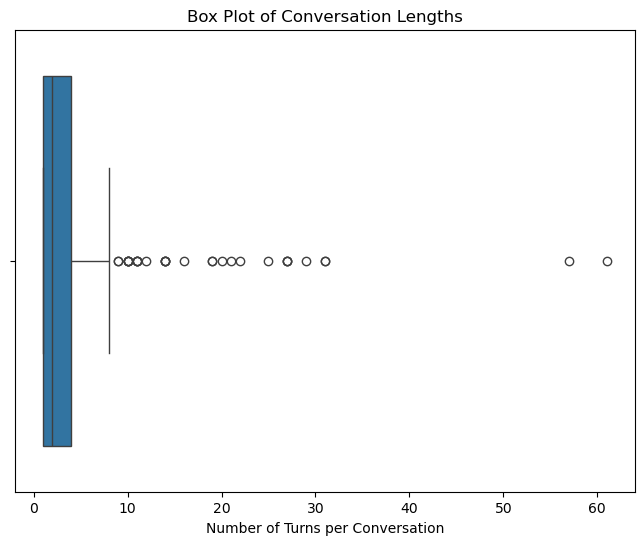

In [10]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x=conversation_lengths)
plt.xlabel("Number of Turns per Conversation")
plt.title("Box Plot of Conversation Lengths")
plt.show()

# RQ 3: Determining how accurate we can predict the length of a conversation based on the initial prompt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   URL                 300 non-null    object 
 1   Type                300 non-null    object 
 2   ID                  123 non-null    object 
 3   Author              300 non-null    object 
 4   Points              122 non-null    float64
 5   Title               122 non-null    object 
 6   ChatURL             300 non-null    object 
 7   DateOfConversation  300 non-null    object 
 8   Prompt              300 non-null    object 
 9   Answer              300 non-null    object 
 10  ListOfCode          300 non-null    object 
 11  ProcessedPrompt     300 non-null    object 
 12  Topic               300 non-null    int64  
 13  IssueCategory       300 non-null    object 
 14  NumTurns            300 non-null    int64  
dtypes: float64(1), int64(2), object(12)
memory usage: 37.5+ K

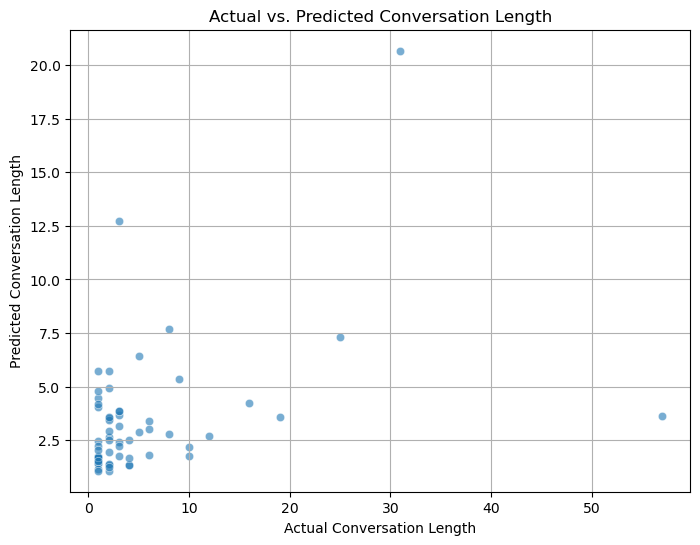

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Identify the Correct Prompt Column
if "Prompt_x" in combined_df.columns:
    combined_df.rename(columns={"Prompt_x": "Prompt"}, inplace=True)

# Step 2: Keep only the first prompt of each conversation
first_prompts = combined_df.sort_values(by=["URL", "DateOfConversation"]).groupby("URL").first().reset_index()

# Step 3: Compute Conversation Length (NumTurns)
conversation_lengths = combined_df.groupby("URL").size().reset_index(name="NumTurns")  # Corrected method

# Step 4: Merge NumTurns back with first prompts
first_prompts = first_prompts.merge(conversation_lengths, on="URL", how="left")

# Fix duplicated column names: Keep the correct NumTurns column
if "NumTurns_y" in first_prompts.columns:
    first_prompts = first_prompts.drop(columns=["NumTurns_x"], errors="ignore")  # Drop the old column
    first_prompts = first_prompts.rename(columns={"NumTurns_y": "NumTurns"})  # Rename the correct column

# Ensure the final structure
print(first_prompts.info())  # Check that there's only one "NumTurns"


# Ensure NumTurns is now available
if "NumTurns" not in first_prompts.columns:
    raise ValueError("NumTurns column is missing after merge. Check merge operation.")

# Step 5: Convert First Prompts to Numerical Features using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 words
X = vectorizer.fit_transform(first_prompts["Prompt"].astype(str)).toarray()

# Step 6: Define Target Variable (NumTurns)
y = first_prompts["NumTurns"]

# Step 7: Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train a Machine Learning Model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 9: Predict on Test Data
y_pred = model.predict(X_test)

# Step 10: Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 11: Scatter Plot - Actual vs. Predicted Conversation Length
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Conversation Length")
plt.ylabel("Predicted Conversation Length")
plt.title("Actual vs. Predicted Conversation Length")
plt.grid(True)
plt.show()


## For the following parts, all the two json files we chose should be placed in the root folder.
We chose 20230831_073827_hn_sharings.json and 20230831_061759_issue_sharings.json

In [13]:
import pandas as pd

df = pd.read_json("20230831_073827_hn_sharings.json")
df = pd.json_normalize(df['Sources'])
df = pd.json_normalize(df['ChatgptSharing'])

nested_columns = ['Sources', 'ChatgptSharing'] 
extracted_data = []

for col in nested_columns:
    if col in df.columns:
        flattened = pd.json_normalize(df[col].dropna())
        for col_name in flattened.columns:
            extracted_data.extend(flattened[col_name].dropna().tolist())

for col in df.columns:
    if col not in nested_columns:
        extracted_data.extend(df[col].dropna().tolist())

df = pd.DataFrame({'ExtractedData': extracted_data})
df = pd.json_normalize(df['ExtractedData'])
df = pd.json_normalize(df['Conversations'])

combined_data = pd.DataFrame(columns=['Prompt', 'Answer', 'Conversation'])

for idx, row in df.iterrows():
    conversation_id = idx + 1
    for col in df.columns:
        val = row[col]       
        if isinstance(val, (dict, str)):
            flattened = pd.json_normalize(val)
            if 'Prompt' in flattened.columns and 'Answer' in flattened.columns:
                temp_df = flattened[['Prompt', 'Answer']]
                temp_df['Conversation'] = conversation_id
                combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

combined_data.sort_values('Conversation', inplace=True)
combined_data.reset_index(drop=True, inplace=True)

df2 = pd.read_json("20230831_061759_issue_sharings.json")
df2 = pd.json_normalize(df2['Sources'])
df2 = pd.json_normalize(df2['ChatgptSharing'])

nested_columns = ['Sources', 'ChatgptSharing'] 
extracted_data = []

for col in nested_columns:
    if col in df2.columns:
        flattened = pd.json_normalize(df2[col].dropna())
        for col_name in flattened.columns:
            extracted_data.extend(flattened[col_name].dropna().tolist())

for col in df2.columns:
    if col not in nested_columns:
        extracted_data.extend(df2[col].dropna().tolist())

df2 = pd.DataFrame({'ExtractedData': extracted_data})
df2 = pd.json_normalize(df2['ExtractedData'])
df2 = pd.json_normalize(df2['Conversations'])

combined_data2 = pd.DataFrame(columns=['Prompt', 'Answer', 'Conversation'])

for idx, row in df2.iterrows():
    conversation_id = idx + 1
    for col in df2.columns:
        val = row[col]       
        if isinstance(val, (dict, str)):
            flattened = pd.json_normalize(val)
            if 'Prompt' in flattened.columns and 'Answer' in flattened.columns:
                temp_df = flattened[['Prompt', 'Answer']]
                temp_df['Conversation'] = conversation_id
                combined_data2 = pd.concat([combined_data2, temp_df], ignore_index=True)

combined_data2.sort_values('Conversation', inplace=True)
combined_data2.reset_index(drop=True, inplace=True)



In [14]:
import spacy
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0
nlp = spacy.load("en_core_web_sm")

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

combined_data2['IsEnglish'] = combined_data2['Prompt'].apply(lambda x: is_english(x) if isinstance(x, str) else False)

non_english_conversations = combined_data2.loc[~combined_data2['IsEnglish'], 'Conversation'].unique()

filtered_data = combined_data2[~combined_data2['Conversation'].isin(non_english_conversations)]

filtered_data['Conversation'] = pd.factorize(filtered_data['Conversation'])[0] + 1
filtered_data.reset_index(drop=True, inplace=True)

filtered_data.drop(columns=['IsEnglish'], inplace=True)

def smart_combine(filtered_data, combined_data):
    existing_prompts = set(combined_data["Prompt"])
    max_conv_id = combined_data["Conversation"].max()

    i = 0
    while i < len(filtered_data):
        row = filtered_data.iloc[i]
        
        if row["Prompt"] not in existing_prompts:
            old_conv_id = row["Conversation"]
            mask = (filtered_data["Conversation"] == old_conv_id) & (filtered_data.index >= row.name)
            subset = filtered_data[mask].copy() 

            max_conv_id += 1
            subset["Conversation"] = max_conv_id
            combined_data = pd.concat([combined_data, subset], ignore_index=True)
            
            existing_prompts.update(subset["Prompt"].tolist())

            while i < len(filtered_data) and filtered_data.iloc[i]["Conversation"] == old_conv_id:
                i += 1
        else:
            i += 1   
    return combined_data

final_df = smart_combine(filtered_data, combined_data)
final_df2 = final_df.copy()

conversation_lengths = final_df2.groupby('Conversation').size().reset_index(name='Length')
valid_conversations = conversation_lengths[conversation_lengths['Length'] <= 10]

filtered_df = final_df2[final_df2['Conversation'].isin(valid_conversations['Conversation'])]
filtered_df.reset_index(drop=True, inplace=True)

print(filtered_df)

df = filtered_df.copy()
df['Conversation_Length'] = df.groupby('Conversation')['Conversation'].transform('count')
df = df.drop_duplicates(subset='Conversation', keep='first')

/var/folders/z4/vb4c7h0d7rlg_bvm0nl6lfsm0000gn/T/ipykernel_71963/1804792918.py:19: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  filtered_data['Conversation'] = pd.factorize(filtered_data['Conversation'])[0] + 1
/var/folders/z4/vb4c7h0d7rlg_bvm0nl6lfsm0000gn/T/ipykernel_71963/1804792918.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Conversation'] = pd.factorize(filtered_data['Conversation'])[0] + 1
/var/folders/z4/vb4c7h0d7rlg_bvm0nl6lfsm0000gn/T/ipykernel_71963/1804792918.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

                                                 Prompt  \
0     repair all game theory / hacking attacks and e...   
1     Let's write fizz buzz so it generates at above...   
2     Hmm let's also replace the classical implement...   
3     Ok let's make it even faster, since the only w...   
4     Let's write a 2 paragraph news article on a ca...   
...                                                 ...   
1183  I want to build a python parser to parse the f...   
1184  I need your help to find duplicate issues on m...   
1185  Given a commit hash for Git, I want to switch ...   
1186  what compounds may treat Alternating Hemiplegi...   
1187  Give me a list of 100 compounds (molecules) th...   

                                                 Answer Conversation  
0     Your concept of multi-ledger BFT (Byzantine Fa...            1  
1     Achieving a throughput of 55GB/s or more when ...            2  
2     Sure! Pre-calculating an array for FizzBuzz is...            2  
3     G

In [15]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

nlp = spacy.load("en_core_web_sm")
def extract_features(prompt):
    doc = nlp(prompt)
    num_tokens = len(doc) 
    num_sentences = len(list(doc.sents)) 
    avg_token_length = np.mean([len(token) for token in doc])  
    num_entities = len(doc.ents) 
    lexical_diversity = len(set(token.text.lower() for token in doc if token.is_alpha)) / num_tokens 
    return num_tokens, num_sentences, avg_token_length, num_entities, lexical_diversity

df['PromptFeatures'] = df['Prompt'].apply(lambda x: extract_features(str(x)))
df[['NumTokens', 'NumSentences', 'AvgTokenLength', 'NumEntities', 'LexicalDiversity']] = pd.DataFrame(
    df['PromptFeatures'].tolist(), index=df.index)

df.drop('PromptFeatures', axis=1, inplace=True)

vectorizer = TfidfVectorizer(max_features=100)
X_prompt = vectorizer.fit_transform(df['Prompt']).toarray()

X = np.hstack([df[['NumTokens', 'NumSentences', 'AvgTokenLength', 'NumEntities', 'LexicalDiversity']].values, X_prompt])

y = df['Conversation_Length']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = model.score(X_test, y_test)
print(f'R-squared: {r2}')
# Step 8: Function to Predict Conversation Length for a New Prompt
def predict_conversation_length(prompt):
    features = extract_features(prompt)
    prompt_vectorized = vectorizer.transform([prompt]).toarray()
    input_features = np.hstack([np.array(features).reshape(1, -1), prompt_vectorized])
    return model.predict(input_features)[0]

new_prompt = "How can I write a Python script to sort my dataset?"
print(f"Predicted conversation length: {predict_conversation_length(new_prompt)}")


/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mean Squared Error: 2.511380388223879
R-squared: -0.12100574796869612
Predicted conversation length: 2.55


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load a BERT-based sentence transformer
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for all prompts
df['PromptEmbedding'] = df['Prompt'].apply(lambda x: embed_model.encode(x))

# Convert embeddings to a DataFrame
embedding_df = pd.DataFrame(df['PromptEmbedding'].tolist())

# Prepare dataset
X = embedding_df
y = df['Conversation_Length']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model (XGBoost or RandomForest)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from textblob import TextBlob

initial_prompts = final_df2.groupby('Conversation').first().reset_index()
conversation_lengths = final_df2.groupby('Conversation').size().reset_index(name='Length')

initial_prompts = initial_prompts.merge(conversation_lengths, on='Conversation')

initial_prompts['PromptLength'] = initial_prompts['Prompt'].apply(len)  # Character count
initial_prompts['WordCount'] = initial_prompts['Prompt'].apply(lambda x: len(x.split()))  # Word count
initial_prompts['Sentiment'] = initial_prompts['Prompt'].apply(lambda x: TextBlob(x).sentiment.polarity)  # Sentiment polarity

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_features = vectorizer.fit_transform(initial_prompts['Prompt'])

# Combine TF-IDF and other features
X = pd.concat([pd.DataFrame(tfidf_features.toarray()), initial_prompts[['PromptLength', 'WordCount', 'Sentiment']]], axis=1)
y = initial_prompts['Length']

# Convert column names to strings
X.columns = X.columns.astype(str)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Mean Squared Error: 36.96423882732733
